# インポート

In [46]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import pickle

#ベクトル化
from transformers import BertJapaneseTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from sentence_transformers import models
import torch

#OneHotエンコーディング
from sklearn.preprocessing import OneHotEncoder

#LightGBM
import lightgbm as lgb
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)

#DNN
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses

#決定木
from sklearn.tree import DecisionTreeClassifier

# 翻訳
# -*- coding: utf-8
from googletrans import Translator
translator = Translator()

## googletransでエラーが出る場合

AttributeError: 'NoneType' object has no attribute 'group'  
このエラーが出る場合はバージョンが問題らしい  
一旦、アンインストールして

In [ ]:
!pip uninstall googletrans

バージョンを指定して入れなおす

In [ ]:
!pip install googletrans==3.1.0a0

## データの読み込み

In [8]:
df = pd.read_csv("../data/vector_split.csv",index_col=0)
df_text = df.iloc[:,:2]
df_vector = df.iloc[:,2:]
df_status = pd.read_csv("../data/status.csv", index_col=0)
df_onehot = pd.read_csv("../data/onehot.csv", index_col=0)
display(df_text.head(1))
display(df_onehot.head(1))
display(df_vector.head(1))
display(df_status)

,text,sentiment
0,ぼけっとしてたらこんな時間。チャリあるから食べにでたいのに…,-1


,sentiment_-1,sentiment_0,sentiment_1
0,1.0,0.0,0.0


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,-0.045897,-0.214199,-0.36531,-0.151727,-0.344921,-0.158282,0.058233,-0.224733,0.042998,-0.355706,...,-0.042891,-0.457397,0.447057,-0.041747,-0.020145,-0.624823,-0.035998,-0.201487,0.255674,-0.37993


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
mean,-0.008007,-0.094317,-0.054998,-0.165922,-0.142793,0.097898,0.038515,-0.033088,0.036804,-0.187420,...,-0.134448,-0.144797,0.266466,-0.010633,-0.065683,-0.392149,0.113740,-0.191146,0.054516,-0.052569
std,0.165550,0.167544,0.196841,0.152516,0.178113,0.173617,0.150423,0.172896,0.165181,0.175988,...,0.146223,0.168301,0.198516,0.154091,0.166551,0.200744,0.162681,0.159359,0.179604,0.177977
min,-1.085665,-1.788969,-1.314229,-0.976173,-1.014553,-0.678122,-0.772185,-1.355776,-0.819011,-0.991892,...,-1.030011,-1.337411,-1.123794,-0.983034,-0.760269,-1.652097,-1.003777,-0.945995,-1.784324,-1.296932
max,0.643333,0.996532,1.388678,0.964208,0.857462,2.048091,0.925388,0.711329,1.574542,0.854583,...,0.648653,1.145675,1.925123,1.253330,0.711414,0.666830,1.013699,0.971638,0.806236,0.904413


## ベクトルの正規化

In [9]:
display(df_vector.head(3))
df_vector_norm = df_vector
for i in range(len(df_vector.T)):
    vec_min = df_status.iat[2,i]
    vec_max = df_status.iat[3,i]
    df_vector_norm.iloc[:,i] = (df_vector.iloc[:,i] - vec_min) / (vec_max - vec_min)
display(df_vector_norm.head(3))
df_vector.iloc[:,:5].std()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,-0.045897,-0.214199,-0.365310,-0.151727,-0.344921,-0.158282,0.058233,-0.224733,0.042998,-0.355706,...,-0.042891,-0.457397,0.447057,-0.041747,-0.020145,-0.624823,-0.035998,-0.201487,0.255674,-0.379930
1,-0.104059,-0.160933,-0.231748,-0.029837,-0.271681,-0.118083,0.118344,-0.036794,0.140905,-0.360428,...,0.022478,-0.362644,0.367586,-0.125338,0.032311,-0.476081,0.205891,-0.097674,0.078120,-0.010167
2,-0.078176,-0.217044,0.009032,-0.181265,-0.204240,-0.014866,0.061512,0.007916,-0.015457,-0.269055,...,-0.086051,-0.268181,0.442382,-0.166084,-0.284402,-0.398496,0.133986,-0.076781,0.113673,-0.274367


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_758,vector_759,vector_760,vector_761,vector_762,vector_763,vector_764,vector_765,vector_766,vector_767
0,0.601370,0.565345,0.351074,0.424889,0.357707,0.190682,0.489180,0.547163,0.360138,0.344540,...,0.588039,0.354404,0.515216,0.420901,0.502910,0.442996,0.479698,0.388243,0.787474,0.416565
1,0.567731,0.584468,0.400488,0.487706,0.396830,0.205427,0.524590,0.638082,0.401043,0.341983,...,0.626980,0.392563,0.489151,0.383523,0.538553,0.507138,0.599595,0.442379,0.718935,0.584536
2,0.582701,0.564324,0.489570,0.409666,0.432856,0.243288,0.491111,0.659711,0.335716,0.391468,...,0.562328,0.430605,0.513683,0.365303,0.323349,0.540595,0.563954,0.453274,0.732659,0.464518


vector_0    0.095749
vector_1    0.060149
vector_2    0.072826
vector_3    0.078601
vector_4    0.095145
dtype: float64

# 多クラス分類
## ３手法を組み合わせて推定する
LightGBM：  
https://mathmatical22.xyz/2020/04/11/%E3%80%90%E5%88%9D%E5%AD%A6%E8%80%85%E5%90%91%E3%81%91%E3%80%91lightgbm-%E5%9F%BA%E6%9C%AC%E7%9A%84%E3%81%AA%E4%BD%BF%E3%81%84%E6%96%B9-%E5%A4%9A%E3%82%AF%E3%83%A9%E3%82%B9%E5%88%86%E9%A1%9E%E7%B7%A8/  
  
DNN：  
https://atmarkit.itmedia.co.jp/ait/articles/2006/08/news031_2.html  
https://qiita.com/AlphaMikeNeko/items/8cac3db70c18e28eb652

決定木：  
https://qiita.com/renesisu727/items/844648d6c60e578ce944

## LightGBM

### 説明変数と目的変数

In [10]:
X = df_vector
y = df["sentiment"]

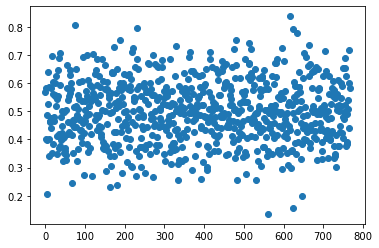

In [12]:
plt.scatter(range(len(X.T)),X.iloc[1,:])
plt.show()

### トレーニングデータとテストデータの分割

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=2, stratify=y)

In [14]:
print(f"X_train:{len(X_train)}\nX_test:{len(X_test)}\ny_train:{len(y_train)}\ny_test:{len(y_test)}")

X_train:26250
X_test:8750
y_train:26250
y_test:8750


### モデルの学習

In [17]:
# モデルの学習
model_lgb = lgb.LGBMClassifier() # モデルのインスタンスの作成
model_lgb.fit(X_train, y_train) # モデルの学習

# テストデータの予測クラス (予測クラス(-1 or 0 or 1)を返す)
y_pred = model_lgb.predict(X_test)
# テストデータのクラス予測確率 (各クラスの予測確率 [クラス0の予測確率,クラス1の予測確率,クラス2の予測確率] を返す)
y_pred_prob = model_lgb.predict_proba(X_test)

### 予測値の確認

In [18]:
# 真値と予測値の表示
df_pred = pd.DataFrame({'target':y_test,'target_pred':y_pred})
display(df_pred.head(3))

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame({'y':y_test, '-1_prob':y_pred_prob[:,0], '0_prob':y_pred_prob[:,1], '1_prob':y_pred_prob[:,2]})
display(df_pred_prob.head(3))

,target,target_pred
20297,0,0
10658,1,1
11517,-1,1


,y,-1_prob,0_prob,1_prob
20297,0,0.124273,0.596781,0.278946
10658,1,0.026316,0.131246,0.842438
11517,-1,0.226859,0.298727,0.474414


### モデルの保存と読み込み

In [20]:
with open('../model/lgb.pkl', 'wb') as model_file:
    pickle.dump(model_lgb, model_file)

In [21]:
#読み込み
with open('../model/lgb.pkl', 'rb') as model_file:
    model_lgb = pickle.load(model_file)

## DNN

### TensorFlowがGPUを認識しているか確認

In [23]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15027727433106876039
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4763828224
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1748274911932146070
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
 xla_global_id: 416903419]

### 説明変数と目的変数

In [24]:
X = df_vector.to_numpy()
y = df_onehot.to_numpy()

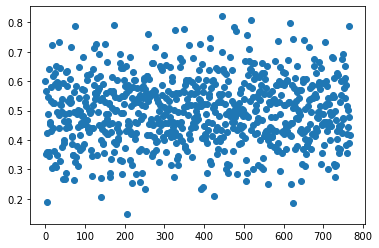

In [25]:
plt.scatter(range(len(X.T)),X[0])
plt.show()

### トレーニングデータとテストデータの分割

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=2,stratify=y)

In [27]:
print(f"X_train:{len(X_train)}\nX_test:{len(X_test)}\ny_train:{len(y_train)}\ny_test:{len(y_test)}")

X_train:26250
X_test:8750
y_train:26250
y_test:8750


### モデルの作成

In [32]:
len_X = len(X_train[0])
model_dnn = Sequential(
    [
        Input(shape=(len_X,)),
        Dense(len_X,activation="sigmoid"),
        Dropout(0.2),
        Dense(3,activation="softmax")
    ]
)

#モデルのサマリ(全体像)を表示
model_dnn.summary()

#コンパイル
model_dnn.compile(optimizer = Adam(),
                  loss = 'categorical_crossentropy',
                  metrics=['categorical_accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 768)               590592    
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 2307      
                                                                 
Total params: 592,899
Trainable params: 592,899
Non-trainable params: 0
_________________________________________________________________


### モデルの学習

In [33]:
result = model_dnn.fit(
    X_train,                #訓練データ
    y_train,                #ラベル
    epochs = 500,     #エポック数
    batch_size = 5000,    #ミニバッチのサイズ
    verbose = 2,
    validation_data=(X_test, y_test)
)

Epoch 1/500
6/6 - 1s - loss: 1.5366 - categorical_accuracy: 0.3325 - val_loss: 1.3474 - val_categorical_accuracy: 0.3849 - 885ms/epoch - 148ms/step
Epoch 2/500
6/6 - 0s - loss: 1.3103 - categorical_accuracy: 0.3339 - val_loss: 1.1004 - val_categorical_accuracy: 0.3694 - 142ms/epoch - 24ms/step
Epoch 3/500
6/6 - 0s - loss: 1.2074 - categorical_accuracy: 0.3451 - val_loss: 1.1326 - val_categorical_accuracy: 0.3253 - 144ms/epoch - 24ms/step
Epoch 4/500
6/6 - 0s - loss: 1.1701 - categorical_accuracy: 0.3443 - val_loss: 1.1329 - val_categorical_accuracy: 0.3280 - 143ms/epoch - 24ms/step
Epoch 5/500
6/6 - 0s - loss: 1.1437 - categorical_accuracy: 0.3524 - val_loss: 1.1109 - val_categorical_accuracy: 0.3581 - 141ms/epoch - 23ms/step
Epoch 6/500
6/6 - 0s - loss: 1.1239 - categorical_accuracy: 0.3629 - val_loss: 1.0779 - val_categorical_accuracy: 0.4153 - 145ms/epoch - 24ms/step
Epoch 7/500
6/6 - 0s - loss: 1.1088 - categorical_accuracy: 0.3788 - val_loss: 1.0655 - val_categorical_accuracy: 0.5

Epoch 57/500
6/6 - 0s - loss: 0.8868 - categorical_accuracy: 0.5883 - val_loss: 0.8763 - val_categorical_accuracy: 0.5993 - 145ms/epoch - 24ms/step
Epoch 58/500
6/6 - 0s - loss: 0.8879 - categorical_accuracy: 0.5869 - val_loss: 0.8730 - val_categorical_accuracy: 0.6003 - 140ms/epoch - 23ms/step
Epoch 59/500
6/6 - 0s - loss: 0.8836 - categorical_accuracy: 0.5874 - val_loss: 0.8723 - val_categorical_accuracy: 0.6005 - 141ms/epoch - 23ms/step
Epoch 60/500
6/6 - 0s - loss: 0.8812 - categorical_accuracy: 0.5879 - val_loss: 0.8720 - val_categorical_accuracy: 0.6011 - 148ms/epoch - 25ms/step
Epoch 61/500
6/6 - 0s - loss: 0.8841 - categorical_accuracy: 0.5842 - val_loss: 0.8730 - val_categorical_accuracy: 0.6022 - 143ms/epoch - 24ms/step
Epoch 62/500
6/6 - 0s - loss: 0.8827 - categorical_accuracy: 0.5858 - val_loss: 0.8683 - val_categorical_accuracy: 0.6023 - 141ms/epoch - 24ms/step
Epoch 63/500
6/6 - 0s - loss: 0.8789 - categorical_accuracy: 0.5890 - val_loss: 0.8720 - val_categorical_accurac

Epoch 113/500
6/6 - 0s - loss: 0.8527 - categorical_accuracy: 0.6037 - val_loss: 0.8530 - val_categorical_accuracy: 0.6136 - 141ms/epoch - 23ms/step
Epoch 114/500
6/6 - 0s - loss: 0.8539 - categorical_accuracy: 0.6033 - val_loss: 0.8577 - val_categorical_accuracy: 0.6030 - 143ms/epoch - 24ms/step
Epoch 115/500
6/6 - 0s - loss: 0.8552 - categorical_accuracy: 0.6048 - val_loss: 0.8552 - val_categorical_accuracy: 0.6115 - 147ms/epoch - 24ms/step
Epoch 116/500
6/6 - 0s - loss: 0.8534 - categorical_accuracy: 0.6036 - val_loss: 0.8580 - val_categorical_accuracy: 0.5995 - 145ms/epoch - 24ms/step
Epoch 117/500
6/6 - 0s - loss: 0.8529 - categorical_accuracy: 0.6053 - val_loss: 0.8459 - val_categorical_accuracy: 0.6119 - 142ms/epoch - 24ms/step
Epoch 118/500
6/6 - 0s - loss: 0.8478 - categorical_accuracy: 0.6112 - val_loss: 0.8434 - val_categorical_accuracy: 0.6119 - 140ms/epoch - 23ms/step
Epoch 119/500
6/6 - 0s - loss: 0.8451 - categorical_accuracy: 0.6092 - val_loss: 0.8396 - val_categorical_

Epoch 168/500
6/6 - 0s - loss: 0.8312 - categorical_accuracy: 0.6159 - val_loss: 0.8331 - val_categorical_accuracy: 0.6145 - 141ms/epoch - 23ms/step
Epoch 169/500
6/6 - 0s - loss: 0.8315 - categorical_accuracy: 0.6146 - val_loss: 0.8304 - val_categorical_accuracy: 0.6187 - 140ms/epoch - 23ms/step
Epoch 170/500
6/6 - 0s - loss: 0.8310 - categorical_accuracy: 0.6173 - val_loss: 0.8318 - val_categorical_accuracy: 0.6190 - 144ms/epoch - 24ms/step
Epoch 171/500
6/6 - 0s - loss: 0.8315 - categorical_accuracy: 0.6159 - val_loss: 0.8342 - val_categorical_accuracy: 0.6166 - 145ms/epoch - 24ms/step
Epoch 172/500
6/6 - 0s - loss: 0.8340 - categorical_accuracy: 0.6160 - val_loss: 0.8296 - val_categorical_accuracy: 0.6192 - 139ms/epoch - 23ms/step
Epoch 173/500
6/6 - 0s - loss: 0.8281 - categorical_accuracy: 0.6187 - val_loss: 0.8304 - val_categorical_accuracy: 0.6167 - 141ms/epoch - 24ms/step
Epoch 174/500
6/6 - 0s - loss: 0.8301 - categorical_accuracy: 0.6185 - val_loss: 0.8319 - val_categorical_

Epoch 223/500
6/6 - 0s - loss: 0.8213 - categorical_accuracy: 0.6230 - val_loss: 0.8291 - val_categorical_accuracy: 0.6153 - 143ms/epoch - 24ms/step
Epoch 224/500
6/6 - 0s - loss: 0.8226 - categorical_accuracy: 0.6213 - val_loss: 0.8256 - val_categorical_accuracy: 0.6192 - 141ms/epoch - 23ms/step
Epoch 225/500
6/6 - 0s - loss: 0.8226 - categorical_accuracy: 0.6195 - val_loss: 0.8225 - val_categorical_accuracy: 0.6218 - 142ms/epoch - 24ms/step
Epoch 226/500
6/6 - 0s - loss: 0.8237 - categorical_accuracy: 0.6211 - val_loss: 0.8318 - val_categorical_accuracy: 0.6163 - 142ms/epoch - 24ms/step
Epoch 227/500
6/6 - 0s - loss: 0.8227 - categorical_accuracy: 0.6214 - val_loss: 0.8307 - val_categorical_accuracy: 0.6211 - 147ms/epoch - 24ms/step
Epoch 228/500
6/6 - 0s - loss: 0.8252 - categorical_accuracy: 0.6207 - val_loss: 0.8237 - val_categorical_accuracy: 0.6192 - 164ms/epoch - 27ms/step
Epoch 229/500
6/6 - 0s - loss: 0.8199 - categorical_accuracy: 0.6253 - val_loss: 0.8216 - val_categorical_

Epoch 278/500
6/6 - 0s - loss: 0.8155 - categorical_accuracy: 0.6279 - val_loss: 0.8188 - val_categorical_accuracy: 0.6239 - 139ms/epoch - 23ms/step
Epoch 279/500
6/6 - 0s - loss: 0.8144 - categorical_accuracy: 0.6288 - val_loss: 0.8187 - val_categorical_accuracy: 0.6231 - 143ms/epoch - 24ms/step
Epoch 280/500
6/6 - 0s - loss: 0.8161 - categorical_accuracy: 0.6246 - val_loss: 0.8230 - val_categorical_accuracy: 0.6206 - 142ms/epoch - 24ms/step
Epoch 281/500
6/6 - 0s - loss: 0.8171 - categorical_accuracy: 0.6250 - val_loss: 0.8213 - val_categorical_accuracy: 0.6256 - 141ms/epoch - 24ms/step
Epoch 282/500
6/6 - 0s - loss: 0.8153 - categorical_accuracy: 0.6269 - val_loss: 0.8171 - val_categorical_accuracy: 0.6248 - 143ms/epoch - 24ms/step
Epoch 283/500
6/6 - 0s - loss: 0.8135 - categorical_accuracy: 0.6269 - val_loss: 0.8185 - val_categorical_accuracy: 0.6231 - 144ms/epoch - 24ms/step
Epoch 284/500
6/6 - 0s - loss: 0.8173 - categorical_accuracy: 0.6259 - val_loss: 0.8384 - val_categorical_

Epoch 333/500
6/6 - 0s - loss: 0.8152 - categorical_accuracy: 0.6259 - val_loss: 0.8185 - val_categorical_accuracy: 0.6258 - 141ms/epoch - 23ms/step
Epoch 334/500
6/6 - 0s - loss: 0.8150 - categorical_accuracy: 0.6248 - val_loss: 0.8250 - val_categorical_accuracy: 0.6229 - 142ms/epoch - 24ms/step
Epoch 335/500
6/6 - 0s - loss: 0.8129 - categorical_accuracy: 0.6301 - val_loss: 0.8157 - val_categorical_accuracy: 0.6256 - 141ms/epoch - 23ms/step
Epoch 336/500
6/6 - 0s - loss: 0.8120 - categorical_accuracy: 0.6276 - val_loss: 0.8192 - val_categorical_accuracy: 0.6221 - 144ms/epoch - 24ms/step
Epoch 337/500
6/6 - 0s - loss: 0.8119 - categorical_accuracy: 0.6266 - val_loss: 0.8242 - val_categorical_accuracy: 0.6219 - 144ms/epoch - 24ms/step
Epoch 338/500
6/6 - 0s - loss: 0.8121 - categorical_accuracy: 0.6247 - val_loss: 0.8211 - val_categorical_accuracy: 0.6206 - 143ms/epoch - 24ms/step
Epoch 339/500
6/6 - 0s - loss: 0.8140 - categorical_accuracy: 0.6262 - val_loss: 0.8291 - val_categorical_

Epoch 388/500
6/6 - 0s - loss: 0.8043 - categorical_accuracy: 0.6311 - val_loss: 0.8115 - val_categorical_accuracy: 0.6264 - 144ms/epoch - 24ms/step
Epoch 389/500
6/6 - 0s - loss: 0.8044 - categorical_accuracy: 0.6300 - val_loss: 0.8115 - val_categorical_accuracy: 0.6282 - 138ms/epoch - 23ms/step
Epoch 390/500
6/6 - 0s - loss: 0.8061 - categorical_accuracy: 0.6297 - val_loss: 0.8171 - val_categorical_accuracy: 0.6218 - 142ms/epoch - 24ms/step
Epoch 391/500
6/6 - 0s - loss: 0.8056 - categorical_accuracy: 0.6312 - val_loss: 0.8177 - val_categorical_accuracy: 0.6290 - 143ms/epoch - 24ms/step
Epoch 392/500
6/6 - 0s - loss: 0.8055 - categorical_accuracy: 0.6324 - val_loss: 0.8120 - val_categorical_accuracy: 0.6249 - 141ms/epoch - 23ms/step
Epoch 393/500
6/6 - 0s - loss: 0.8041 - categorical_accuracy: 0.6300 - val_loss: 0.8149 - val_categorical_accuracy: 0.6242 - 143ms/epoch - 24ms/step
Epoch 394/500
6/6 - 0s - loss: 0.8062 - categorical_accuracy: 0.6291 - val_loss: 0.8142 - val_categorical_

Epoch 443/500
6/6 - 0s - loss: 0.8016 - categorical_accuracy: 0.6350 - val_loss: 0.8193 - val_categorical_accuracy: 0.6254 - 142ms/epoch - 24ms/step
Epoch 444/500
6/6 - 0s - loss: 0.8016 - categorical_accuracy: 0.6328 - val_loss: 0.8114 - val_categorical_accuracy: 0.6263 - 143ms/epoch - 24ms/step
Epoch 445/500
6/6 - 0s - loss: 0.8012 - categorical_accuracy: 0.6345 - val_loss: 0.8138 - val_categorical_accuracy: 0.6246 - 139ms/epoch - 23ms/step
Epoch 446/500
6/6 - 0s - loss: 0.8023 - categorical_accuracy: 0.6352 - val_loss: 0.8121 - val_categorical_accuracy: 0.6315 - 141ms/epoch - 24ms/step
Epoch 447/500
6/6 - 0s - loss: 0.8013 - categorical_accuracy: 0.6330 - val_loss: 0.8133 - val_categorical_accuracy: 0.6246 - 144ms/epoch - 24ms/step
Epoch 448/500
6/6 - 0s - loss: 0.8016 - categorical_accuracy: 0.6332 - val_loss: 0.8108 - val_categorical_accuracy: 0.6318 - 141ms/epoch - 24ms/step
Epoch 449/500
6/6 - 0s - loss: 0.8030 - categorical_accuracy: 0.6336 - val_loss: 0.8087 - val_categorical_

Epoch 498/500
6/6 - 0s - loss: 0.7967 - categorical_accuracy: 0.6362 - val_loss: 0.8061 - val_categorical_accuracy: 0.6319 - 141ms/epoch - 23ms/step
Epoch 499/500
6/6 - 0s - loss: 0.7973 - categorical_accuracy: 0.6342 - val_loss: 0.8086 - val_categorical_accuracy: 0.6326 - 140ms/epoch - 23ms/step
Epoch 500/500
6/6 - 0s - loss: 0.7950 - categorical_accuracy: 0.6367 - val_loss: 0.8059 - val_categorical_accuracy: 0.6320 - 136ms/epoch - 23ms/step


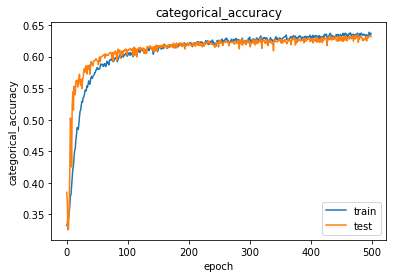

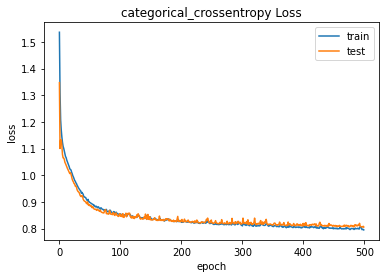

In [34]:
# Accuracyのプロット
plt.figure()
plt.title('categorical_accuracy')
plt.xlabel('epoch')
plt.ylabel('categorical_accuracy')
plt.plot(result.history['categorical_accuracy'], label='train')
plt.plot(result.history['val_categorical_accuracy'], label='test')
plt.legend()

# Lossのプロット
plt.figure()
plt.title('categorical_crossentropy Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend()
plt.show()

In [35]:
# model.evaluateを使用し、学習を終えたモデルの誤差と精度を呼び出し
train_score = model_dnn.evaluate(X_train, y_train)
test_score = model_dnn.evaluate(X_test, y_test)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

274/274 [==============================] - 1s 3ms/step - loss: 0.8059 - categorical_accuracy: 0.6320
Train loss: 0.785848081111908
Train accuracy: 0.6431618928909302
Test loss: 0.805910587310791
Test accuracy: 0.6320000290870667


### モデルの保存と読み込み

In [39]:
#保存
model_dnn.save("../model/dnn")

INFO:tensorflow:Assets written to: ../model/dnn\assets


In [41]:
#読み込み
model_dnn = tf.keras.models.load_model("../model/dnn")

## 決定木

### 説明変数と目的変数

In [44]:
X = df_vector
y = df["sentiment"]

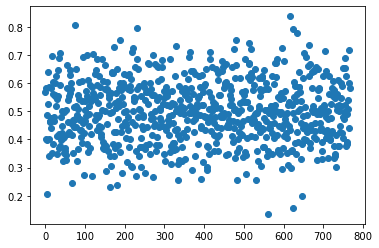

In [45]:
plt.scatter(range(len(X.T)),X.iloc[1,:])
plt.show()

### トレーニングデータとテストデータの分割

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=2,stratify=y)
print(f"X_train:{len(X_train)}\nX_test:{len(X_test)}\ny_train:{len(y_train)}\ny_test:{len(y_test)}")

X_train:26250
X_test:8750
y_train:26250
y_test:8750


### モデルの学習

In [50]:
b = []
for i in range(10):
    clf_model = DecisionTreeClassifier(max_depth=i+1)
    clf_model.fit(X_train, y_train)
    b.append({"depth":i+1,"score":clf_model.score(X_test, y_test)})
    print(f"max_depth:{i+1},score:{clf_model.score(X_test, y_test)}")
_df = pd.DataFrame(b)
depth = _df[_df["score"] == _df["score"].max()].iat[0,0]

clf_model = DecisionTreeClassifier(max_depth=depth)
clf_model.fit(X_train, y_train)

max_depth:1,score:0.42114285714285715
max_depth:2,score:0.4376
max_depth:3,score:0.45645714285714284
max_depth:4,score:0.4777142857142857
max_depth:5,score:0.4794285714285714
max_depth:6,score:0.48022857142857145
max_depth:7,score:0.4864
max_depth:8,score:0.47782857142857144
max_depth:9,score:0.4718857142857143
max_depth:10,score:0.4681142857142857


DecisionTreeClassifier(max_depth=7)

### モデルの保存と読み込み

In [52]:
#保存
with open('../model/clf.pkl', 'wb') as model_file:
    pickle.dump(clf_model, model_file)

In [53]:
#読み込み
with open('../model/clf.pkl', 'rb') as model_file:
    model_clf = pickle.load(model_file)